## Data collection

In [64]:
import pandas as pd
import numpy as np
import requests
import time

The dataset selected initially is "Air Quality Annual Summary" from the Environmental Protection Agency (EPA) of the US (I haven't found anything even remotely comprehensive and solid for Russia), provides a comprehensive overview of air quality measurements across various locations and years. It spans from 1987 to 2017, including data from different states, providing a broad geographical representation of air quality conditions.The dataset covers a wide array of air quality parameters, including both pollutants and non-pollutants. Parameters such as ozone, particulate matter, and various pollutants are measured and reported. I will focus on harmful pollutants for this research.

In [ ]:
!kaggle datasets download -d epa/air-quality

In [117]:
data_historic = pd.read_csv("C:\\Users\\Victo\\Downloads\\epa_air_quality_annual_summary.csv")
data_historic.head(5)

C:\Users\Victo\AppData\Local\Temp\ipykernel_4552\565861268.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_historic = pd.read_csv("C:\\Users\\Victo\\Downloads\\epa_air_quality_annual_summary.csv")


,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,...,seventy_five_percentile,fifty_percentile,ten_percentile,local_site_name,address,state_name,county_name,city_name,cbsa_name,date_of_last_change
0,20,57,1,82134,1,37.771964,-100.018190,WGS84,Molybdenum PM10 STP,24 HOUR,...,0.00000,0.0,0.0,DODGE CITY,PUMP STATION 2100 1ST AVE,Kansas,Ford,Dodge City,Dodge City KS,2012-08-11
1,18,163,12,42401,1,38.021727,-87.569458,WGS84,Sulfur dioxide,3-HR BLK AVG,...,3.60000,1.3,0.0,Evansville CAAP,425 WEST MILL ROAD/ FIRE STATION #17,Indiana,Vanderburgh,Evansville,Evansville IN-KY,2013-02-16
2,40,31,9000,88152,1,34.732404,-98.713351,WGS84,Phosphorus PM2.5 LC,24 HOUR,...,0.00000,0.0,0.0,NaN,Wichita Mountains,Oklahoma,Comanche,NaN,Lawton OK,2016-02-26
3,32,3,561,42601,1,36.163959,-115.113916,WGS84,Nitric oxide (NO),1 HOUR,...,18.80000,0.9,0.0,Sunrise Acres,2501 SUNRISE AVENUE,Nevada,Clark,Las Vegas,Las Vegas-Henderson-Paradise NV,2015-03-20
4,13,127,3001,12154,1,31.185187,-81.485166,WGS84,Selenium (TSP) STP,24 HOUR,...,0.00064,0.0,0.0,NaN,BRUNSWICK COASTAL COLLEGE,Georgia,Glynn,Brunswick,Brunswick GA,2015-07-22


In [7]:
data_historic.shape

(2038710, 55)

In [49]:
parameter_names = list(data_historic.parameter_name.unique())
print(len(parameter_names), parameter_names)

1134 ['Molybdenum PM10 STP', 'Sulfur dioxide', 'Phosphorus PM2.5 LC', 'Nitric oxide (NO)', 'Selenium (TSP) STP', 'Black Carbon PM2.5 at 880 nm', 'Phosphorus PM10-2.5 STP', 'Coarse Mass Extinction PM2.5 LC', 'Benzene', 'Ethylene dichloride', 'Elemental Carbon Extinction PM2.5 LC', 'Carbon monoxide', 'Manganese (TSP) STP', 'Cadmium (TSP) STP', 'Ozone', 'Ethylene dibromide', 'PM2.5 - Local Conditions', 'OC1 PM2.5 LC', 'Calcium PM2.5 STP', '123-Trimethylbenzene', 'Tin PM2.5 LC', 'PM10 Total 0-10um STP', 'Sample Flow Rate- CV', 'Manganese PM10 STP', 'Sample Min Baro Pressure', 'n-Pentane', 'Indium PM2.5 LC', '13-Butadiene', 'cis-2-Pentene', 'Ethylbenzene', 'Tungsten PM2.5 LC', 'Methyl tert-butyl ether', 'Average Ambient Temperature', 'Manganese PM2.5 LC', 'Acetylene', 'Ethyl acrylate', 'Molybdenum (TSP) STP', 'Carbon disulfide', 'Arsenic (TSP) STP', 'Wind Speed - Resultant', 'Sample Max Baro Pressure', 'Methyl Butyl Ketone', '3-Methyl-1-butene', 'OC CSN_Rev Unadjusted PM2.5 LC TOR', 'Total 

For possible machine learning tasks I decided to narrow down parameters from (LITERALLY INSANE) 1134 options (and I wondered why the dataset was so large...) to only basic urban pollutants. 

I selected those, that are proclaimed as such by EPA itself.

In [118]:
paramsto_filter_list = [12103, 12105, 12110, 12112, 12115, 12128, 12132, 12136, 14115, 43218, 43502, 43503, 43505,
         43509, 43802, 43803, 43804, 43815, 43817, 43818, 43824, 43829, 43830, 43831, 43843, 43860,
         45201, 82103, 82105, 82110, 82112, 82128, 82132, 82136,82142,88103,88105,88110,88112,88128,
         88132, 88136]
data_historic = data_historic.query('parameter_code in @paramsto_filter_list')
data_historic.shape

(199388, 55)

Now I would use Air Quality System (AQS) API from the same EPA of the USofA to enhance our dataset with recent years (from 2018 to 2022) while 2023 annual data is not ready yet (obviously). 

In [91]:
# data_modern = data_historic.drop(data_historic.index)
data_modern = pd.DataFrame(columns=['state_code','county_code','site_number','parameter_code','poc','latitude','longitude', 'datum',
                                   'parameter', 'sample_duration_code', 'sample_duration', 'pollutant_standard', 'metric_used',
                                   'method', 'year', 'units_of_measure', 'event_type', 'observation_count', 'observation_percent',
                                   'validity_indicator', 'valid_day_count', 'required_day_count', 'exceptional_data_count',
                                   'null_observation_count', 'primary_exceedance_count', 'secondary_exceedance_count',
                                   'certification_indicator', 'arithmetic_mean', 'standard_deviation', 'first_max_value', 'first_max_datetime',
                                   'second_max_value', 'second_max_datetime', 'third_max_value', 'third_max_datetime', 'fourth_max_value',
                                   'fourth_max_datetime', 'first_max_nonoverlap_value', 'first_max_n_o_datetime', 'second_max_nonoverlap_value',
                                   'second_max_n_o_datetime', 'ninety_ninth_percentile', 'ninety_eighth_percentile', 'ninety_fifth_percentile',
                                   'ninetieth_percentile', 'seventy_fifth_percentile', 'fiftieth_percentile', 'tenth_percentile', 'local_site_name',
                                   'site_address', 'state', 'county', 'city', 'cbsa_code', 'cbsa', 'date_of_last_change'])


In [11]:
key = 'sandgoose35'
email = 'VictorPakholkov@outlook.com'
base_url = 'https://aqs.epa.gov/data/api/annualData/'

In [90]:
params_list = ["12103,12105,12110,12112,12115", "12128,12132,12136,14115,43218", "43502,43503,43505,43509,43802", 
          "43803,43804,43815,43817,43818", "43824,43829,43830,43831,43843", "43860,45201,82103,82105,82110", 
          "82112,82128,82132,82136,82142", "88103,88105,88110,88112,88128", "88132,88136"]
bdates = ['20180101', '20190101', '20200101', '20210101', '20220101']
edates = ['20181212', '20191212', '20201212', '20211212', '20221212']
states = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
         '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 
          '40', '41', '42', '43', '44', '45', '46','47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '66', '72', '78',
         '80']

In [93]:
# pause_duration = 5.5

for param in params_list:
    for i in range(len(bdates)):
        print(f"Now requesting {param} params for {bdates[i]}")
        for state in states:
            # Construct the parameters for the API request
            api_params = {
                'email': email,
                'key': key,
                'param': param,
                'bdate': bdates[i],
                'edate': edates[i],
                'state': state
            }

            response = requests.get(f'{base_url}byState', params=api_params)
            # time.sleep(pause_duration)
            if response.status_code == 200:
                data = response.json()
                for data_entry in data['Data']:
                    data_to_append = pd.DataFrame([data_entry], columns=list(data_modern.columns))
                    data_modern = pd.concat([data_modern, data_to_append], ignore_index=True)
            else:
                print(f"Request failed for params: {api_params}")
                print(f"Status code: {response.status_code}")
                print(response.text)

Now requesting 12103,12105,12110,12112,12115 params for 20180101
Now requesting 12103,12105,12110,12112,12115 params for 20190101
Now requesting 12103,12105,12110,12112,12115 params for 20200101
Now requesting 12103,12105,12110,12112,12115 params for 20210101
Now requesting 12103,12105,12110,12112,12115 params for 20220101
Now requesting 12128,12132,12136,14115,43218 params for 20180101
Now requesting 12128,12132,12136,14115,43218 params for 20190101
Now requesting 12128,12132,12136,14115,43218 params for 20200101
Now requesting 12128,12132,12136,14115,43218 params for 20210101
Now requesting 12128,12132,12136,14115,43218 params for 20220101
Now requesting 43502,43503,43505,43509,43802 params for 20180101
Now requesting 43502,43503,43505,43509,43802 params for 20190101
Now requesting 43502,43503,43505,43509,43802 params for 20200101
Now requesting 43502,43503,43505,43509,43802 params for 20210101
Now requesting 43502,43503,43505,43509,43802 params for 20220101
Now requesting 43803,4380

In [108]:
data_new_copy = data_modern.copy()
data_new_copy.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,fiftieth_percentile,tenth_percentile,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,01,073,2003,12115,6,33.499722,-86.924167,WGS84,Chromium VI (TSP) STP,7,...,0.00023,0.00001,Wylam,1242 JERSEY ST WYLAM AL,Alabama,Jefferson,Birmingham,13820,"Birmingham-Hoover, AL",2020-05-21
1,06,025,0005,12103,7,32.676180,-115.483070,NAD83,Arsenic (TSP) STP,7,...,0.00087,0.00087,Calexico-Ethel Street,"1029 ETHEL ST, CALEXICO HIGH SCHOOL",California,Imperial,Calexico,20940,"El Centro, CA",2020-05-21
2,06,025,0005,12110,7,32.676180,-115.483070,NAD83,Cadmium (TSP) STP,7,...,0.00065,0.00065,Calexico-Ethel Street,"1029 ETHEL ST, CALEXICO HIGH SCHOOL",California,Imperial,Calexico,20940,"El Centro, CA",2020-05-21
3,06,025,0005,12112,7,32.676180,-115.483070,NAD83,Chromium (TSP) STP,7,...,0.009,0.004,Calexico-Ethel Street,"1029 ETHEL ST, CALEXICO HIGH SCHOOL",California,Imperial,Calexico,20940,"El Centro, CA",2020-05-21
4,06,025,0005,12115,1,32.676180,-115.483070,NAD83,Chromium VI (TSP) STP,7,...,0.0,0.0,Calexico-Ethel Street,"1029 ETHEL ST, CALEXICO HIGH SCHOOL",California,Imperial,Calexico,20940,"El Centro, CA",2020-05-21


In [94]:
print(data_modern.shape)
print(data_modern.head())

(32396, 56)
  state_code county_code site_number parameter_code poc   latitude  \
0         01         073        2003          12115   6  33.499722   
1         06         025        0005          12103   7  32.676180   
2         06         025        0005          12110   7  32.676180   
3         06         025        0005          12112   7  32.676180   
4         06         025        0005          12115   1  32.676180   

    longitude  datum              parameter sample_duration_code  ...  \
0  -86.924167  WGS84  Chromium VI (TSP) STP                    7  ...   
1 -115.483070  NAD83      Arsenic (TSP) STP                    7  ...   
2 -115.483070  NAD83      Cadmium (TSP) STP                    7  ...   
3 -115.483070  NAD83     Chromium (TSP) STP                    7  ...   
4 -115.483070  NAD83  Chromium VI (TSP) STP                    7  ...   

  fiftieth_percentile tenth_percentile        local_site_name  \
0             0.00023          0.00001                  Wylam  

## Data aggregation

Now let's unite both datasets into one:

In [104]:
print([i for i in list(data_historic.columns) + list(data_modern.columns) if i not in list(data_historic.columns) or i not in list(data_modern.columns)])

['site_num', 'parameter_name', 'method_name', 'completeness_indicator', 'null_data_count', 'num_obs_below_mdl', 'arithmetic_standard_dev', 'first_max_non_overlapping_value', 'first_no_max_datetime', 'second_max_non_overlapping_value', 'second_no_max_datetime', 'ninety_nine_percentile', 'ninety_eight_percentile', 'ninety_five_percentile', 'ninety_percentile', 'seventy_five_percentile', 'fifty_percentile', 'ten_percentile', 'address', 'state_name', 'county_name', 'city_name', 'cbsa_name', 'site_number', 'parameter', 'sample_duration_code', 'method', 'validity_indicator', 'null_observation_count', 'standard_deviation', 'first_max_nonoverlap_value', 'first_max_n_o_datetime', 'second_max_nonoverlap_value', 'second_max_n_o_datetime', 'ninety_ninth_percentile', 'ninety_eighth_percentile', 'ninety_fifth_percentile', 'ninetieth_percentile', 'seventy_fifth_percentile', 'fiftieth_percentile', 'tenth_percentile', 'site_address', 'state', 'county', 'city', 'cbsa_code', 'cbsa']


In [110]:
data_modern.rename(columns = {'site_number':'site_num', 
                              'parameter':'parameter_name',
                              'method':'method_name',
                               'null_observation_count' : 'null_data_count',
                             'standard_deviation' : 'arithmetic_standard_dev',
                             'first_max_nonoverlap_value' : 'first_max_non_overlapping_value',
                             'first_max_n_o_datetime' : 'first_no_max_datetime',
                             'second_max_nonoverlap_value' : 'second_max_non_overlapping_value',
                             'second_max_n_o_datetime' : 'second_no_max_datetime',
                             'ninety_ninth_percentile' : 'ninety_nine_percentile',
                             'ninety_eighth_percentile' : 'ninety_eight_percentile',
                             'ninety_fifth_percentile' : 'ninety_five_percentile',
                             'ninetieth_percentile' : 'ninety_percentile',
                             'seventy_fifth_percentile' : 'seventy_five_percentile',
                             'fiftieth_percentile' : 'fifty_percentile',
                             'tenth_percentile' : 'ten_percentile',
                             'site_address' : 'address',
                             'state' : 'state_name',
                             'county' : 'county_name',
                             'city' : 'city_name',
                             'cbsa' : 'cbsa_name'}, inplace = True)

In [112]:
data_modern.drop('sample_duration_code', axis=1, inplace=True)
data_modern.drop('validity_indicator', axis=1, inplace=True)

In [113]:
print(list(data_modern.columns))

['state_code', 'county_code', 'site_num', 'parameter_code', 'poc', 'latitude', 'longitude', 'datum', 'parameter_name', 'sample_duration', 'pollutant_standard', 'metric_used', 'method_name', 'year', 'units_of_measure', 'event_type', 'observation_count', 'observation_percent', 'valid_day_count', 'required_day_count', 'exceptional_data_count', 'null_data_count', 'primary_exceedance_count', 'secondary_exceedance_count', 'certification_indicator', 'arithmetic_mean', 'arithmetic_standard_dev', 'first_max_value', 'first_max_datetime', 'second_max_value', 'second_max_datetime', 'third_max_value', 'third_max_datetime', 'fourth_max_value', 'fourth_max_datetime', 'first_max_non_overlapping_value', 'first_no_max_datetime', 'second_max_non_overlapping_value', 'second_no_max_datetime', 'ninety_nine_percentile', 'ninety_eight_percentile', 'ninety_five_percentile', 'ninety_percentile', 'seventy_five_percentile', 'fifty_percentile', 'ten_percentile', 'local_site_name', 'address', 'state_name', 'county_

In [119]:
data_united = pd.concat([data_historic, data_modern], axis=0)
data_united.shape

(231784, 56)

In [120]:
data_united.isnull().sum(axis = 0)

state_code                               0
county_code                              0
site_num                                 0
parameter_code                           0
poc                                      0
latitude                                 0
longitude                                0
datum                                    0
parameter_name                           0
sample_duration                          0
pollutant_standard                  215186
metric_used                              0
method_name                              0
year                                     0
units_of_measure                         0
event_type                               0
observation_count                        0
observation_percent                      0
completeness_indicator               32396
valid_day_count                          0
required_day_count                       0
exceptional_data_count                   0
null_data_count                          0
primary_exc

Columns primary_exceedance_count, secondary_exceedance_count, first_max_non_overlapping_value, first_no_max_datetime, second_max_non_overlapping_value, second_no_max_datetime, are to be deleted due to all NaNs in both datasets. It may happend due to data collection methodology or regulatory standards and reporting or just broken datasets or many other things, including practical irrelevance for particular basic urban toxins. 'pollutant_standard' & 'cbsa_code' are mostly NaNs and are irrelevant.

In [154]:
data_united.drop('primary_exceedance_count', axis=1, inplace=True)
data_united.drop('secondary_exceedance_count', axis=1, inplace=True)
data_united.drop('first_max_non_overlapping_value', axis=1, inplace=True)
data_united.drop('first_no_max_datetime', axis=1, inplace=True)
data_united.drop('second_max_non_overlapping_value', axis=1, inplace=True)
data_united.drop('second_no_max_datetime', axis=1, inplace=True)
data_united.drop('pollutant_standard', axis=1, inplace=True)
data_united.drop('cbsa_code', axis=1, inplace=True)

## EDA & Vizualizations

Let's look at central tendency measures of numeric varibles in the dataset:

In [155]:
print(data_united.describe())

            latitude      longitude  observation_percent  num_obs_below_mdl  \
count  231784.000000  231784.000000        231784.000000           199388.0   
mean       38.107547     -93.124503            73.714790                0.0   
std         5.656328      17.143267            29.644344                0.0   
min         0.000000    -160.508331             0.000000                0.0   
25%        34.066590    -106.298639            49.000000                0.0   
50%        38.921847     -88.372510            89.000000                0.0   
75%        41.934170     -80.338450            97.000000                0.0   
max        68.637233       0.000000           100.000000                0.0   

       arithmetic_mean  arithmetic_standard_dev  first_max_value  \
count    231784.000000            231784.000000    231784.000000   
mean          0.699748                 0.610251         3.252892   
std          37.813675                31.652503       140.270478   
min          -0.

Now let's look at names of those basic urban toxins, designated by EPA:

In [122]:
print(data_united['parameter_name'].unique())

['Benzene' 'Ethylene dichloride' 'Manganese (TSP) STP' 'Cadmium (TSP) STP'
 'Ethylene dibromide' 'Manganese PM10 STP' '13-Butadiene'
 'Manganese PM2.5 LC' 'Arsenic (TSP) STP' 'Chromium (TSP) STP'
 'Carbon tetrachloride' 'Trichloroethylene' 'trans-13-Dichloropropene'
 'Acetaldehyde' 'Dichloromethane' 'Nickel PM2.5 LC' 'Lead PM2.5 LC'
 '12-Dichloropropane' 'Chloroform' 'Nickel (TSP) STP' 'Vinyl chloride'
 '1122-Tetrachloroethane' 'Formaldehyde' 'Tetrachloroethylene'
 'Lead (TSP) STP' 'Arsenic PM10 STP' 'Beryllium (TSP) STP'
 'cis-13-Dichloropropene' 'Beryllium PM10 STP' 'Arsenic PM2.5 LC'
 'Cadmium PM2.5 LC' 'Acrolein - Unverified' 'Chromium VI (TSP) STP'
 'Chromium PM2.5 LC' 'Cadmium PM10 STP' 'Lead PM10 STP' 'Nickel PM10 STP'
 'Acrolein - Verified' 'Mercury PM10 STP' 'Chromium PM10 STP'
 'Beryllium PM2.5 LC' 'Chromium VI (TSP) LC' '1,3-Butadiene'
 '1,1,2,2-Tetrachloroethane' '1,2-Dichloropropane'
 'trans-1,3-Dichloropropene' 'cis-1,3-Dichloropropene']


According to Google and ChatGPT, they can be categorized meaningfully, and actually some of them are highly dependent on each other, as representing only some measure of the same toxin:

'Manganese (TSP) STP', 'Manganese PM10 STP', 'Manganese PM2.5 LC'
'Chromium (TSP) STP', 'Chromium PM2.5 LC', 'Chromium VI (TSP) STP', 'Chromium PM10 STP', 'Chromium VI (TSP) LC'
'Nickel PM10 STP', 'Nickel PM2.5 LC', 'Nickel (TSP) STP'
'Arsenic PM2.5 LC', 'Arsenic PM10 STP', 'Arsenic (TSP) STP'
'Cadmium (TSP) STP',  'Cadmium PM2.5 LC' , 'Cadmium PM10 STP'
'cis-1,3-Dichloropropene', 'trans-1,3-Dichloropropene', '1,2-Dichloropropane', '1,1,2,2-Tetrachloroethane', 'cis-13-Dichloropropene','1122-Tetrachloroethane','12-Dichloropropane', 'trans-13-Dichloropropene'
'Ethylene dichloride', 'Ethylene dibromide', 'Trichloroethylene', 'Tetrachloroethylene'

Benzene, Chloroform and Formaldehyde are among the most dangerous standalone ones. Let's look at their distribution through the year. The scale (and all further scales) are logarithmic as there are strange huge outliers at some particular dates, probably tracking problems. 

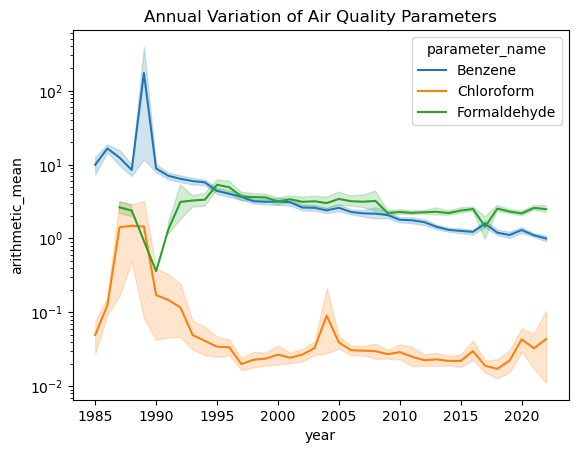

In [179]:
sns.lineplot(data=data_united[((data_united['parameter_name'] == 'Benzene') | (data_united['parameter_name'] == 'Chloroform') | (data_united['parameter_name'] == 'Formaldehyde'))],
             x='year', y='arithmetic_mean', hue='parameter_name')
plt.title('Annual Variation of Air Quality Parameters')
plt.yscale('log')
plt.show()

Benzene was stadily declining since early 90s, whereas chloroform and formaldehyde are quite stable with several peaks. 

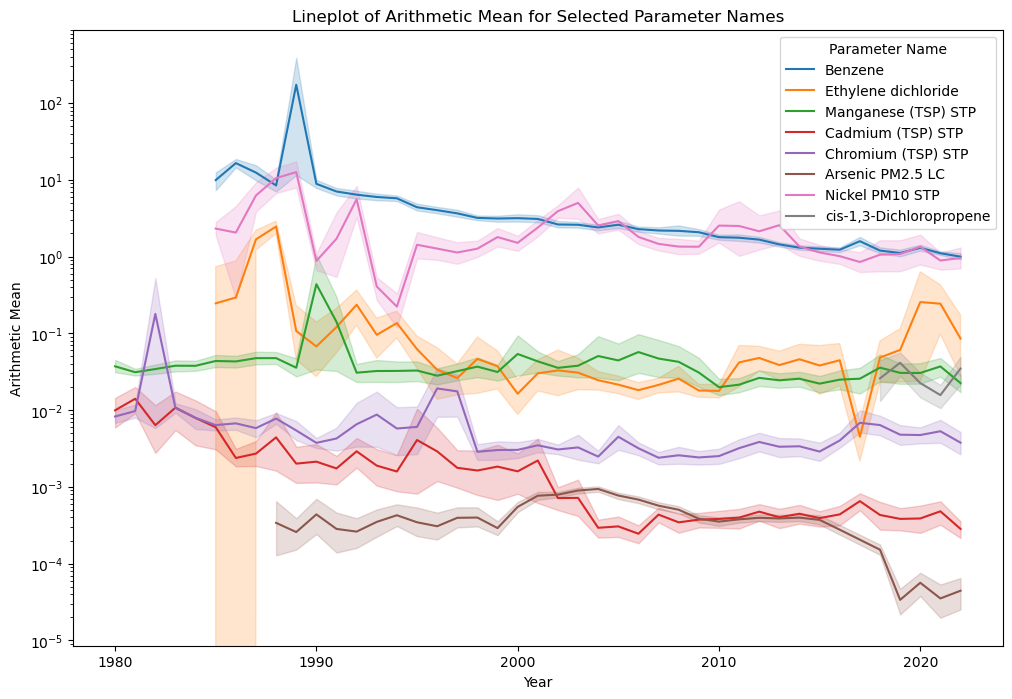

In [178]:
selected_parameter_names = [
    'Manganese (TSP) STP',
    'Chromium (TSP) STP',
    'Nickel PM10 STP',
    'Arsenic PM2.5 LC',
    'Cadmium (TSP) STP',
    'cis-1,3-Dichloropropene',
    'Ethylene dichloride',
    'Benzene'
]

filtered_data = data_united[data_united['parameter_name'].isin(selected_parameter_names)]

plt.figure(figsize=(12, 8))
sns.lineplot(data=filtered_data, x='year', y='arithmetic_mean', hue='parameter_name')

plt.title('Lineplot of Arithmetic Mean for Selected Parameter Names')
plt.xlabel('Year')
plt.ylabel('Arithmetic Mean')
plt.legend(title='Parameter Name')
plt.yscale('log')
plt.show()

When compared across different classes of chemicals, it can be spoted, that the trends in the picture suggest that the levels of the selected pollutants have been decreasing over time. At the same time, the trends are not uniform for all pollutants. Some pollutants, such as manganese (TSP) STP and chromium (TSP) STP, have been fluctuating over time, and it is difficult to say whether there is a clear overall trend. 

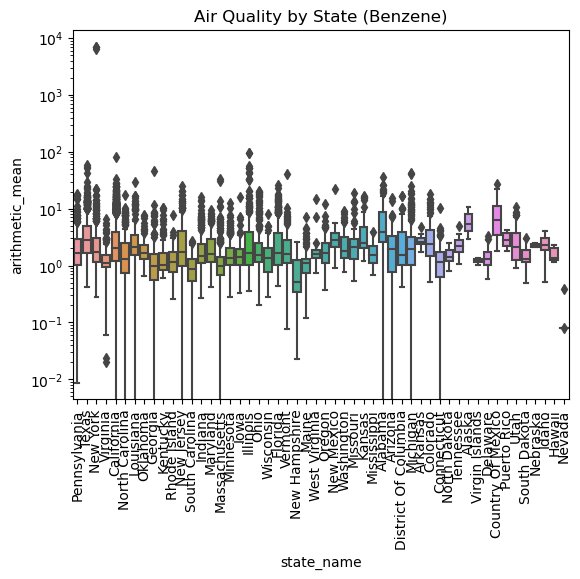

In [185]:
sns.boxplot(data=data_united[data_united['parameter_name'] == 'Benzene'], x='state_name', y='arithmetic_mean') #, hue='parameter_name')
plt.title('Air Quality by State (Benzene)')
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

If taken overall period of observations, for one of the most dangerous pollutants - benzene, the states with the best air quality by its presence are Hawaii, Maine, Alaska, Virginia, and Vermont. The states with the worst air quality by the same metric are California, Arizona, the District of Columbia, Utah, and Nevada. 

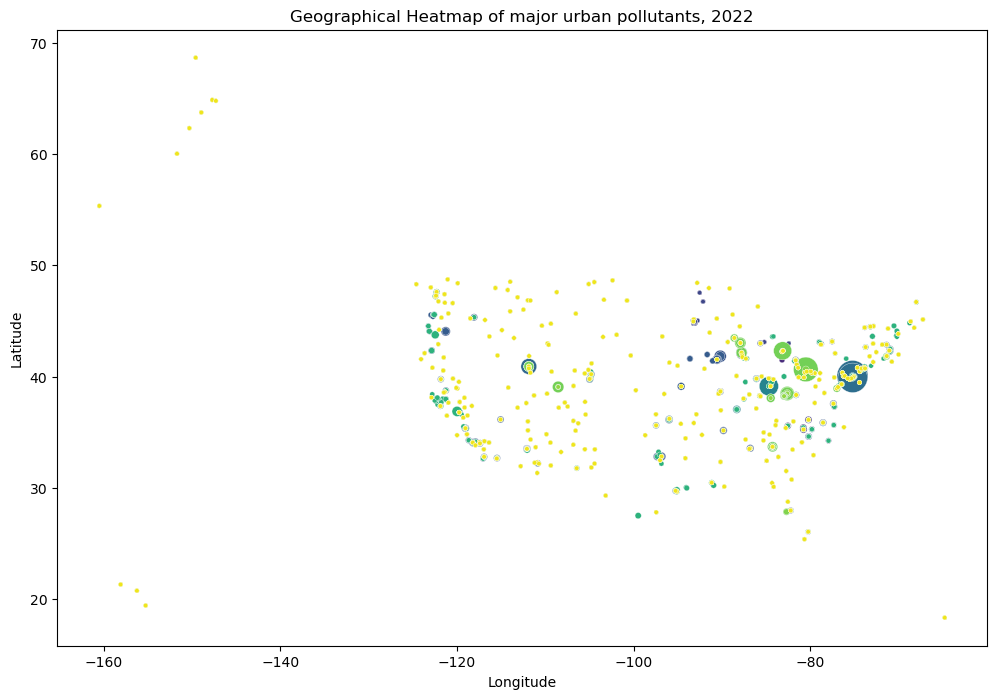

In [186]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='longitude',
    y='latitude',
    hue='parameter_name',
    size='arithmetic_mean',  # You can also use 'size' to represent another variable
    sizes=(10, 500),  # Set the size range for points
    data=data_united[data_united['year']==2022],
    palette='viridis',  # Choose a suitable color palette
)

# Customize the plot as needed
plt.title('Geographical Heatmap of major urban pollutants, 2022')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend([],[], frameon=False)
plt.show()

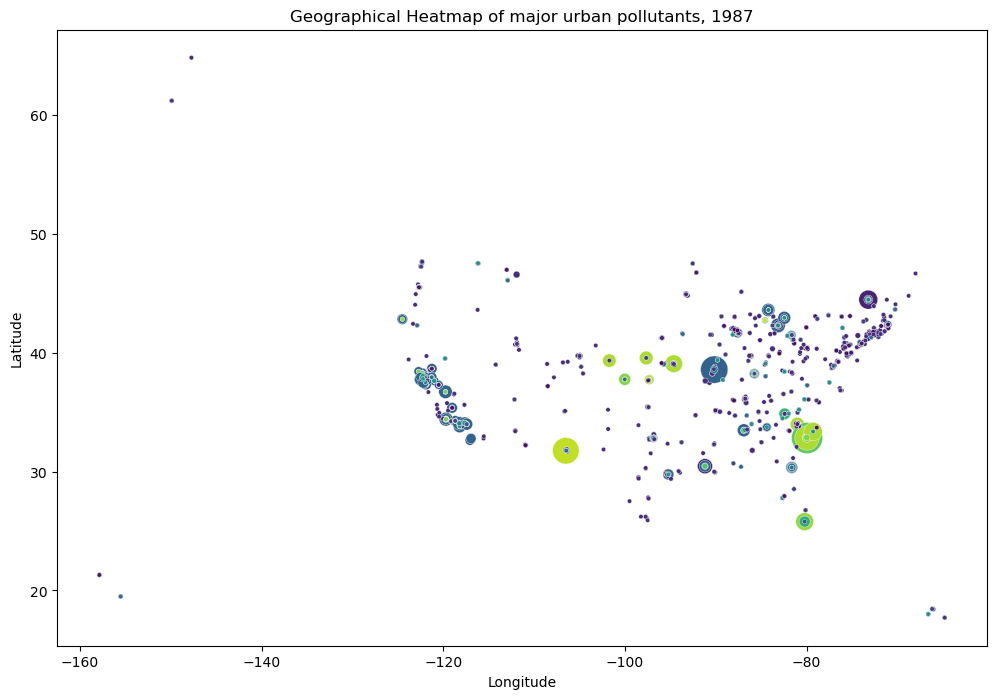

In [187]:
#log_arithmetic_mean = np.log(data_united['arithmetic_mean'])
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='longitude',
    y='latitude',
    hue='parameter_name',
    size='arithmetic_mean',  # You can also use 'size' to represent another variable
    sizes=(10, 500),  # Set the size range for points
    data=data_united[data_united['year']==1987],
    palette='viridis',  # Choose a suitable color palette
)

# Customize the plot as needed
plt.title('Geographical Heatmap of major urban pollutants, 1987')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend([],[], frameon=False)
plt.show()

Here, two geograpghical heatmaps for urban pollutants can be attested (colors are not comparable as they represent different pollutants). 
1987 appears to have fewer data points than the 2022. This could be because pollution monitoring was less widespread in 1987, or because the data for 1987 is incomplete.
2022 shows a different pattern of pollution distribution compared to the previous image. In the 1987, the highest concentration of pollution appears to be in the eastern and central United States, while pollution levels seem to be much lower in the western United States. This suggests that the sources and distribution of pollution may have changed significantly between 1987 and 2022.

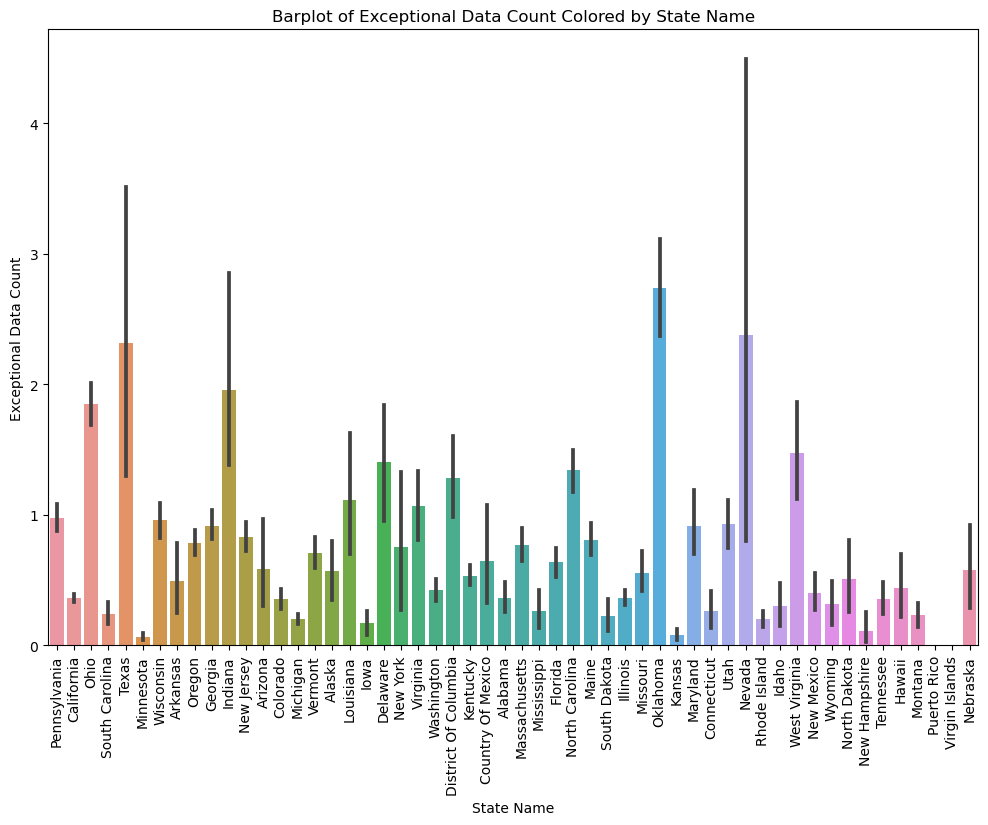

In [183]:
# Plot barplot colored by state_name
plt.figure(figsize=(12, 8))
sns.barplot(data=data_united, x='state_name', y='exceptional_data_count', hue='state_name', dodge=False)

# Customize the plot as needed
plt.title('Barplot of Exceptional Data Count Colored by State Name')
plt.xlabel('State Name')
plt.ylabel('Exceptional Data Count')
plt.legend([],[], frameon=False)
plt.xticks(rotation=90)
plt.show()

The plot shows that the states with the highest number of exceptional data counts are Pennsylvania, California, Ohio, South Carolina, and Texas.
The states with the highest number of exceptional data counts are generally located in the eastern and southern United States.
There is a wide range in the number of exceptional data counts between different states. For example, Pennsylvania has over 20,000 exceptional data counts, while Wyoming has fewer than 1,000 exceptional data counts.
The reasons for the exceptional data counts vary from state to state. For example, the high number of exceptional data counts in Pennsylvania may be due to its large industrial sector, while the high number of exceptional data counts in California may be due to its wildfires.

## Possible Machine Learning Use

Air quality data, sourced from the Environmental Protection Agency (EPA), can be used in several ways within machine learning fiedl.

One primary objective could be the prediction of key air quality metrics and pollutants based on historical data. Employing regression models, including Linear Regression or ensemble methods like Random Forests, could unveil patterns and dependencies within the data. This can empower stakeholders to anticipate air quality levels based on historical information, aiding in proactive decision-making.

Another useful thing could be classification of air quality levels. Algorithms like Logistic Regression, Decision Trees, or Support Vector Machines can  be employed to categorize air quality by co-variance and prevalence of certain pollutains, providing a clearer picture of the broader health implications.

Given the temporal nature of the dataset, time-series analysis can become another meaningful. Techniques like AutoRegressive Integrated Moving Average (ARIMA) or more advanced recurrent neural networks (RNNs) can capture temporal dependencies, enabling the prediction of air quality trends over time.